# The Battle of Neighborhood: Japan Hostels

### Table of Content:  
1. [Introduction/Business Understanding](#1.-Introduction/Business-Understanding)
2. [Analytic Approach](#2.-Analytic-Approach)
3. [Data Requirements](#3.-Data-Requirements)
4. [Data Preparation/Pre-processing](#4.-Data-Preparation/Pre-processing)
5. [Analysis](#5.-Analysis)
6. [Conclusion](#6.-Conclusion)

![Tokyo](images/tokyo.jpg)

## 1. Introduction/Business Understanding

### 1.1 Background

As someone who loves travelling, finding ways to save money and travel low-cost is essential. There's little to save while booking flights and I'd rather pay more to traveling comfortably on a 16Hr flight than try to save and wear myself down even before the trip begins! But we can always save a few bucks on accomodation.

A hostel is a low-budget accommodation shared among travelers. Staying at hostels is an extremely affordable option for travelers. Not only that, It also gives you a chance to expereince which you would never at a hotel. I've found that experiencing hostel life one of the best ways to travel the world on a budget and here’s why:

   1. You'll save a lot of money trust me.
   2. Meet other like-minded travellers and make new friends around the world!
   3. Most hostels organize lot of social activites

### 1.2 Problem Description

Hostel accomodation is a booming industry with the latest rise in tourism worldwide, especially in Asia. Over 20% of the total tourists worldwide are aged between 19-25. And around 80% of them prefer to spend less on accomodation by opting for hostels. This means the demand for hostels is only going to grow further and more people would want to get their legs in the game.

   * How should a new business person decide where to build for a hostel?
   * What factors should he look at before investing?
   * Which neighborhood venues affect a user's rating for location of hostel?

At the same time, it is difficult for a travellers, especially first-timers, to select a hostel from among many options. Hostel reviews are subjective and differ from person-to-person and one cannot solely depend on them to make a decision. It is especially important to consider other aspects like price and neighborhood, which can greatly influence one's experience of the city/country. I will try to answer the following questions

   * How does price vary with location?
   * Where are the 'value of money' hostels located?
   * How does proximity to transportation affect hostel rating?
   * Which hostels are most secure and where are they located?
   * Suggest similar hostel but which cheaper price

For this project, we will be looking at hostels in Japan

### 1.3 Target Audience

This project will serve two groups of audience:

   1. Travellers: Help them make an informed decision while choosing a hostel by providing an in-depth analysis of hostels and their neighborhood.
   2. Business Person: Provide useful information and models which can help them where to open their first/next hostel and how much should they charge.

## 2. Analytic Approach

I will be taking two approaches in the project.

Firstly, I will use exploratory data analysis(EDA) to uncover hidden properties of data and provide useful insights to the reader, both future traveller and investor.

Secondly, I will use prescriptive analytics to help a business person decide a location for new hostel and predict how much should be starting price at the hostel. I will use clustering (KMeans) and regression (Decision Tree Regression)

## 3. Data Requirements

One city will be analysed in this project : **Tokyo**.

Following are the datasets used in the project along with the reasons for choosing them:

**1. [Japan Hostel Dataset](https://www.kaggle.com/koki25ando/hostel-world-dataset)**: This dataset was web scraped from Hostelworld by Koki Ando and is available on Kaggle. This is the core dataset with which I'll work.

**2. [Foursquare API](https://developer.foursquare.com/docs/api)**: This API will help me get the venues around the hostel which I will use for EDA and clustering.

**3. [Tokyo Land Price](https://utinokati.com/en/details/land-market-value/area/Tokyo/)**: I will scrape this website to get land prices of various neighborhoods in Tokyo.

**Note**: Since there is a quota limit on Foursquare, I'll be downloading the data and storing it locally as csv for future use. So we do not have to pull same data again when we restart the data.

Firstly, I will use the list of hostels from Hostel dataset and use Foursquare API to get venues around the Hostel. I will then use EDA to explore the neighborhood and how it affects the price of the hostel. I will also use the combined dataset to cluster similar hostels as per pricing and neighborhood.

Second, I will combine the above data with the land price for the area in which the Hostel is situated and them develop clustering and regression models to predict where a new hostel should be opened and how much should it be priced at.

## 4. Data Preparation/Pre-processing

Let's import all the dependencies before we begin. If we need more, we will add them at a later point. I'll first add whatever I can think of.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy import OpenCage
from sklearn.cluster import KMeans

%matplotlib inline

### 4.1. Hostel Dataset:

Let's first deal with hostels datsaet. I will read the first dataset into a dataframe. For ease of access, I've already downloaded the dataset as csv from Kaggle.

In [8]:
hostel_df = pd.read_csv('data/Hostel.csv')
hostel_df.head()

,Unnamed: 0,hostel.name,City,price.from,Distance,summary.score,rating.band,atmosphere,cleanliness,facilities,location.y,security,staff,valueformoney,lon,lat
0,1,"""Bike & Bed"" CharinCo Hostel",Osaka,3300,2.9km from city centre,9.2,Superb,8.9,9.4,9.3,8.9,9.0,9.4,9.4,135.513767,34.682678
1,2,& And Hostel,Fukuoka-City,2600,0.7km from city centre,9.5,Superb,9.4,9.7,9.5,9.7,9.2,9.7,9.5,NaN,NaN
2,3,&And Hostel Akihabara,Tokyo,3600,7.8km from city centre,8.7,Fabulous,8.0,7.0,9.0,8.0,10.0,10.0,9.0,139.777472,35.697447
3,4,&And Hostel Ueno,Tokyo,2600,8.7km from city centre,7.4,Very Good,8.0,7.5,7.5,7.5,7.0,8.0,6.5,139.783667,35.712716
4,5,&And Hostel-Asakusa North-,Tokyo,1500,10.5km from city centre,9.4,Superb,9.5,9.5,9.0,9.0,9.5,10.0,9.5,139.798371,35.727898


We will drop the 1st column and rename other columns to make them more readable.

In [9]:
columns = ['Name', 'City', 'StartPrice', 'DistanceFromCityCentre', 'OverallScore', 
           'RatingCategory', 'Atmosphere', 'Cleanliness', 'Facilities', 'Location', 
           'Security', 'Staff', 'ValueForMoney', 'Longitude', 'Latitude']

In [10]:
hostel_df.drop(['Unnamed: 0'], axis=1, inplace=True)
hostel_df.columns = columns
hostel_df.head()

,Name,City,StartPrice,DistanceFromCityCentre,OverallScore,RatingCategory,Atmosphere,Cleanliness,Facilities,Location,Security,Staff,ValueForMoney,Longitude,Latitude
0,"""Bike & Bed"" CharinCo Hostel",Osaka,3300,2.9km from city centre,9.2,Superb,8.9,9.4,9.3,8.9,9.0,9.4,9.4,135.513767,34.682678
1,& And Hostel,Fukuoka-City,2600,0.7km from city centre,9.5,Superb,9.4,9.7,9.5,9.7,9.2,9.7,9.5,NaN,NaN
2,&And Hostel Akihabara,Tokyo,3600,7.8km from city centre,8.7,Fabulous,8.0,7.0,9.0,8.0,10.0,10.0,9.0,139.777472,35.697447
3,&And Hostel Ueno,Tokyo,2600,8.7km from city centre,7.4,Very Good,8.0,7.5,7.5,7.5,7.0,8.0,6.5,139.783667,35.712716
4,&And Hostel-Asakusa North-,Tokyo,1500,10.5km from city centre,9.4,Superb,9.5,9.5,9.0,9.0,9.5,10.0,9.5,139.798371,35.727898


In [11]:
print("Number of Hostels: ", hostel_df.shape[0])

Number of Hostels:  342


Let's check if any hostels are missing location data since that is essential for our analysis.

In [12]:
print("Num of hostels with missing Longitude: ", hostel_df.Longitude.isna().sum())

Num of hostels with missing Longitude:  44


In [13]:
print("Num of hostels with missing Latitude: ", hostel_df.Latitude.isna().sum())

Num of hostels with missing Latitude:  44


In [14]:
# Remove hostels with missing latitude and longitude 
hostel_df = hostel_df[hostel_df.Longitude.isna() == False]
hostel_df = hostel_df[hostel_df.Latitude.isna() == False]
hostel_df.shape

(298, 15)

If we see the DistanceFromCityCentre column, we see that it has distance as well as text, let's remove the unwanted text.

In [15]:
hostel_df.DistanceFromCityCentre = hostel_df.DistanceFromCityCentre.replace(r'[^\d\.]+', '', regex=True)
hostel_df.head()

,Name,City,StartPrice,DistanceFromCityCentre,OverallScore,RatingCategory,Atmosphere,Cleanliness,Facilities,Location,Security,Staff,ValueForMoney,Longitude,Latitude
0,"""Bike & Bed"" CharinCo Hostel",Osaka,3300,2.9,9.2,Superb,8.9,9.4,9.3,8.9,9.0,9.4,9.4,135.513767,34.682678
2,&And Hostel Akihabara,Tokyo,3600,7.8,8.7,Fabulous,8.0,7.0,9.0,8.0,10.0,10.0,9.0,139.777472,35.697447
3,&And Hostel Ueno,Tokyo,2600,8.7,7.4,Very Good,8.0,7.5,7.5,7.5,7.0,8.0,6.5,139.783667,35.712716
4,&And Hostel-Asakusa North-,Tokyo,1500,10.5,9.4,Superb,9.5,9.5,9.0,9.0,9.5,10.0,9.5,139.798371,35.727898
5,1night1980hostel Tokyo,Tokyo,2100,9.4,7.0,Very Good,5.5,8.0,6.0,6.0,8.5,8.5,6.5,139.786950,35.724384


Let's do a final check if any more values are missing and what we want to do about them

In [16]:
hostel_df.count()

Name                      298
City                      298
StartPrice                298
DistanceFromCityCentre    298
OverallScore              298
RatingCategory            298
Atmosphere                298
Cleanliness               298
Facilities                298
Location                  298
Security                  298
Staff                     298
ValueForMoney             298
Longitude                 298
Latitude                  298
dtype: int64

No more missing values.
Let's check if the datatype of each column is proper

In [17]:
hostel_df.dtypes

Name                       object
City                       object
StartPrice                  int64
DistanceFromCityCentre     object
OverallScore              float64
RatingCategory             object
Atmosphere                float64
Cleanliness               float64
Facilities                float64
Location                  float64
Security                  float64
Staff                     float64
ValueForMoney             float64
Longitude                 float64
Latitude                  float64
dtype: object

In [18]:
# Convert DistanceFromCityCentre to float64
hostel_df.DistanceFromCityCentre = hostel_df.DistanceFromCityCentre.astype('float')
hostel_df.dtypes

Name                       object
City                       object
StartPrice                  int64
DistanceFromCityCentre    float64
OverallScore              float64
RatingCategory             object
Atmosphere                float64
Cleanliness               float64
Facilities                float64
Location                  float64
Security                  float64
Staff                     float64
ValueForMoney             float64
Longitude                 float64
Latitude                  float64
dtype: object

In [19]:
hostel_df.head()

,Name,City,StartPrice,DistanceFromCityCentre,OverallScore,RatingCategory,Atmosphere,Cleanliness,Facilities,Location,Security,Staff,ValueForMoney,Longitude,Latitude
0,"""Bike & Bed"" CharinCo Hostel",Osaka,3300,2.9,9.2,Superb,8.9,9.4,9.3,8.9,9.0,9.4,9.4,135.513767,34.682678
2,&And Hostel Akihabara,Tokyo,3600,7.8,8.7,Fabulous,8.0,7.0,9.0,8.0,10.0,10.0,9.0,139.777472,35.697447
3,&And Hostel Ueno,Tokyo,2600,8.7,7.4,Very Good,8.0,7.5,7.5,7.5,7.0,8.0,6.5,139.783667,35.712716
4,&And Hostel-Asakusa North-,Tokyo,1500,10.5,9.4,Superb,9.5,9.5,9.0,9.0,9.5,10.0,9.5,139.798371,35.727898
5,1night1980hostel Tokyo,Tokyo,2100,9.4,7.0,Very Good,5.5,8.0,6.0,6.0,8.5,8.5,6.5,139.786950,35.724384


Let's create a new dataframe for tokyo hostels.

In [20]:
tokyo_hostels_df = hostel_df[hostel_df.City == "Tokyo"]

Everything looks good here. Let's move on to fetch neighborhood data using Foursquare API.

### 4.2 Neighborhood Data(Foursquare):

In [21]:
search_url = 'https://api.foursquare.com/v2/venues/search'
explore_url = 'https://api.foursquare.com/v2/venues/explore'

In [22]:
CLIENT_ID = "SQ4TU3K4NAMZXHJE3SKEZRPFNEIEGZLRNBLA1Q3RYNSSTM2C" # your Foursquare ID
CLIENT_SECRET = "DPEFN2TWB4PEZYVZ344CYIZJQINORSO03MFUHNCUBFOYRNGY" # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [23]:
sample_hotel = hostel_df.loc[0]
sample_hotel.Name

'"Bike & Bed" CharinCo Hostel'

In [24]:
params = dict(
  client_id=CLIENT_ID,
  client_secret=CLIENT_SECRET,
  v=VERSION,
  ll=f"{sample_hotel.Latitude}, {sample_hotel.Longitude}",
  radius=500,
  limit=100,
  sortByPopularity=1
)

In [25]:
def get_recommended_venues(name, lattitude, longitude, limit=100, radius=500):
    venues = []
    params = dict(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        v=VERSION,
        ll=f"{lattitude}, {longitude}",
        radius=radius,
        limit=limit,
        sortByPopularity=1
    )
    data = requests.get(explore_url, params=params).json()['response']['groups'][0]['items']
    for v in data:
        v = v['venue']
        primary_cat = ""
        for c in v['categories']:
            if(c['primary']):
                primary_cat=c['name']
        venues.append({
            'HostelName':name, 
            'VenueName': v['name'], 
            'Category': primary_cat, 
            'VenueLatitue': v['location']['lat'], 
            'VenueLongtitude': v['location']['lng']
        })
    return venues

In [26]:
venue_list = []

In [27]:
for name, lat, long in zip(hostel_df.Name, hostel_df.Latitude, hostel_df.Longitude):
    venue_list.extend(get_recommended_venues(name, lat, long))
    i = len(venue_list)
    print(i)

75
175
258
296
329
394
472
503
545
637
711
776
870
893
931
996
1096
1196
1296
1386
1486
1558
1609
1699
1799
1835
1883
1955
1965
2014
2036
2136
2236
2336
2436
2536
2636
2736
2776
2876
2952
3052
3152
3175
3275
3375
3475
3531
3578
3678
3735
3823
3865
3917
4017
4052
4088
4188
4215
4315
4389
4458
4526
4572
4631
4667
4767
4839
4911
5011
5038
5064
5164
5217
5270
5317
5401
5452
5552
5588
5605
5626
5657
5689
5749
5789
5827
5927
5955
5965
6010
6110
6163
6192
6237
6258
6310
6353
6380
6480
6503
6530
6580
6680
6780
6846
6906
6951
6997
7070
7123
7157
7195
7227
7288
7388
7466
7566
7636
7736
7771
7817
7866
7866
7888
7935
8006
8036
8096
8128
8160
8218
8265
8365
8465
8527
8578
8599
8699
8772
8863
8963
9018
9118
9179
9279
9327
9427
9518
9579
9615
9674
9702
9802
9868
9968
10068
10154
10217
10256
10309
10402
10423
10431
10531
10615
10645
10745
10792
10857
10920
11020
11120
11220
11314
11414
11514
11614
11698
11769
11816
11910
11937
11992
12084
12124
12170
12181
12186
12257
12300
12400
12430
12465
12496
125

In [28]:
venues_df = pd.DataFrame(venue_list)
venues_df = venues_df.rename(columns={'VenueLatitue': 'VenueLatitude', 'VenueLongtitude': 'VenueLongitude'})
venues_df.head()

,HostelName,VenueName,Category,VenueLatitude,VenueLongitude
0,"""Bike & Bed"" CharinCo Hostel",McDonald's (マクドナルド),Fast Food Restaurant,34.683110,135.517074
1,"""Bike & Bed"" CharinCo Hostel",Lawson (ローソン 和泉町店),Convenience Store,34.679905,135.511993
2,"""Bike & Bed"" CharinCo Hostel",Tanimachi Line Platform 1 (谷町線 1番線ホーム),Platform,34.683267,135.517259
3,"""Bike & Bed"" CharinCo Hostel",7-Eleven (セブンイレブン 大阪谷町3丁目店),Convenience Store,34.683509,135.517793
4,"""Bike & Bed"" CharinCo Hostel",FamilyMart (ファミリーマート 谷町三丁目店),Convenience Store,34.683407,135.517021


Let's create a new dataframe for venues for hostels in tokyo.

In [29]:
tokyo_venues_df = venues_df[venues_df.HostelName.isin(tokyo_hostels_df.Name)]

In [30]:
tokyo_venues_df.head()

,HostelName,VenueName,Category,VenueLatitude,VenueLongitude
75,&And Hostel Akihabara,Akihabara Station (秋葉原駅),Train Station,35.698357,139.773120
76,&And Hostel Akihabara,Yodobashi-Akiba (ヨドバシカメラ マルチメディアAkiba),Electronics Store,35.698713,139.774761
77,&And Hostel Akihabara,Akihabara Electric Town Exit (秋葉原駅 電気街口),Train Station,35.698818,139.772570
78,&And Hostel Akihabara,THE IDOLM@STER Official Shop (アイドルマスター オフィシャルシ...,Hobby Shop,35.698364,139.772298
79,&And Hostel Akihabara,Shosen Book Tower (書泉ブックタワー),Bookstore,35.697324,139.775157


In [31]:
tokyo_venues_df.shape

(8575, 5)

### 4.3 Land Price Data(Foursquare):

I will scrape the following URL to get land prices in tokyo - https://utinokati.com/en/details/land-market-value/area/Tokyo/

In [32]:
land_price_url = 'https://utinokati.com/en/details/land-market-value/area/Tokyo/'

data = BeautifulSoup(requests.get(land_price_url).content)

In [33]:
price_df = pd.read_html(data.find('table', {'class':'table-condensed'}).prettify())[0]

In [34]:
price_df.drop(['#', 'Average Trading Price'], axis=1, inplace=True)
price_df.rename(columns={'Average Unit Price': 'PricePerSqMeter', 'Area': 'Neighborhood'}, inplace=True)
price_df.PricePerSqMeter = price_df.PricePerSqMeter.apply(lambda x: x.strip(' JPY/sq.m').replace(',', '')).astype(int)

In [35]:
price_df.head()

,Neighborhood,PricePerSqMeter
0,Chiyoda-Ku,2839779
1,Chuo-Ku,1876597
2,Minato-Ku,2075876
3,Shinjuku-Ku,875098
4,Bunkyo-Ku,952715


In [36]:
print(price_df.Neighborhood.sort_values())

20              Adachi-Ku
47            Akiruno-Shi
29           Akishima-Shi
17             Arakawa-Ku
4               Bunkyo-Ku
0              Chiyoda-Ku
30              Chofu-Shi
1                 Chuo-Ku
22             Edogawa-Ku
28              Fuchu-Shi
38              Fussa-Shi
23           Hachioji-Shi
46             Hamura-Shi
42      Higashikurume-Shi
35    Higashimurayama-Shi
40      Higashiyamato-Shi
34               Hino-Shi
45              Inagi-Shi
18            Itabashi-Ku
21          Katsushika-Ku
16                Kita-Ku
41             Kiyose-Shi
33            Kodaira-Shi
32            Koganei-Shi
36          Kokubunji-Shi
39              Komae-Shi
7                 Koto-Ku
52         Kozushima-Mura
37          Kunitachi-Shi
31            Machida-Shi
9               Meguro-Ku
2               Minato-Ku
26             Mitaka-Shi
43    Musashimurayama-Shi
25          Musashino-Shi
13              Nakano-Ku
19              Nerima-Ku
51           Niijima-Mura
49          

Let's remove -ku suffix from all the neighborhood names

In [37]:
price_df.Neighborhood.replace("(Ku)", "", regex=True, inplace=True)

In [70]:
price_df.Neighborhood.replace("(-)", "", regex=True, inplace=True)

In [71]:
price_df.head()

,Neighborhood,PricePerSqMeter
0,Chiyoda,2839779
1,Chuo,1876597
2,Minato,2075876
3,Shinjuku,875098
4,Bunkyo,952715


The hostels dataset doesn't contain information on the locality of the hostel. We'll use reverse geocoding for this purpose. I'm using a free account on OpenCage for this purpose.

We'll try the API with one Hostel and then write function to do the same for all hostels in tokyo.

In [39]:
temp = tokyo_hostels_df.iloc[1]
temp.to_frame().T

,Name,City,StartPrice,DistanceFromCityCentre,OverallScore,RatingCategory,Atmosphere,Cleanliness,Facilities,Location,Security,Staff,ValueForMoney,Longitude,Latitude
3,&And Hostel Ueno,Tokyo,2600,8.7,7.4,Very Good,8.0,7.5,7.5,7.5,7.0,8.0,6.5,139.783667,35.712716


In [41]:
from opencage.geocoder import OpenCageGeocode

geo = OpenCageGeocode("6695ee80f4d844b39e8d188c42459138")

In [42]:
results = geo.reverse_geocode(temp.Latitude, temp.Longitude)

In [55]:
results[0]['formatted']

'unnamed road, Higashiueno 6-chome, Taito, 110-8766, Japan'

In [44]:
import time

address = []
for lat, long in zip(tokyo_hostels_df.Latitude, tokyo_hostels_df.Longitude):
    loc = geo.reverse_geocode(lat, long)[0]
    address.append(loc['formatted'])
    time.sleep(1)

In [66]:
type(address)

list

In [67]:
tokyo_hostels_df["Address"] = address

2          unnamed road, Kanda, Chiyoda, 101-0025, Japan
3      unnamed road, Higashiueno 6-chome, Taito, 110-...
4      unnamed road, Nihonzutsumi 2-chome, Taito, 111...
5      unnamed road, Shitaya 3-chome, Taito, 110-0004...
6      328 Hostel&Lounge, 8 Shuto Expressway Route 1 ...
                             ...                        
334    Wise Owl, Shin-ohashi-dori, Nihonbashi-Kayabac...
337    Yadoya Guest House, Okubo-dori Avenue, Nakano ...
338    unnamed road, Nakano 5-chome, Nakano, 164-0001...
339    ナポリ楽器店, Oji-Kanamachi-Edogawa Line, 柴又一丁目, Kat...
341          はせがわ, 環状三号線, Azabu, Minato, 106-0044, Japan
Name: Address, Length: 116, dtype: object

In [72]:
neighborhood = []
for addr in tokyo_hostels_df.Address:
    for nb in price_df.Neighborhood:
        if nb.lower() in addr.lower():
            neighborhood.append(nb)
            break
    else:
        print("No nb found for ", addr)
        neighborhood.append(np.nan)

No nb found for  unnamed road, Kawasaki Ward, Kawasaki, Kanagawa Prefecture 210-0023, Japan


In [73]:
print("Current number of hostels: ", tokyo_hostels_df.shape[0])

Current number of hostels:  116


In [74]:
tokyo_hostels_df['Neighborhood'] = neighborhood

<ipython-input-74-836258b14639>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokyo_hostels_df['Neighborhood'] = neighborhood


In [75]:
tokyo_hostels_df = tokyo_hostels_df[tokyo_hostels_df.Neighborhood.isna() == False]

In [76]:
print("New number of hostels: ", tokyo_hostels_df.shape[0])

New number of hostels:  115


In [77]:
tokyo_hostels_df.head()

,Name,City,StartPrice,DistanceFromCityCentre,OverallScore,RatingCategory,Atmosphere,Cleanliness,Facilities,Location,Security,Staff,ValueForMoney,Longitude,Latitude,Address,Neighborhood
2,&And Hostel Akihabara,Tokyo,3600,7.8,8.7,Fabulous,8.0,7.0,9.0,8.0,10.0,10.0,9.0,139.777472,35.697447,"unnamed road, Kanda, Chiyoda, 101-0025, Japan",Chiyoda
3,&And Hostel Ueno,Tokyo,2600,8.7,7.4,Very Good,8.0,7.5,7.5,7.5,7.0,8.0,6.5,139.783667,35.712716,"unnamed road, Higashiueno 6-chome, Taito, 110-...",Taito
4,&And Hostel-Asakusa North-,Tokyo,1500,10.5,9.4,Superb,9.5,9.5,9.0,9.0,9.5,10.0,9.5,139.798371,35.727898,"unnamed road, Nihonzutsumi 2-chome, Taito, 111...",Taito
5,1night1980hostel Tokyo,Tokyo,2100,9.4,7.0,Very Good,5.5,8.0,6.0,6.0,8.5,8.5,6.5,139.786950,35.724384,"unnamed road, Shitaya 3-chome, Taito, 110-0004...",Taito
6,328 Hostel & Lounge,Tokyo,3300,16.5,9.3,Superb,8.7,9.7,9.3,9.1,9.3,9.7,8.9,139.745467,35.548044,"328 Hostel&Lounge, 8 Shuto Expressway Route 1 ...",Ota


### 4.4 Persist all datasets for later use

In [78]:
hostel_df.to_pickle('data/hostels_cleaned.pkl')
venues_df.to_pickle('data/hostel_venues.pkl')
price_df.to_pickle('data/tokyo_land_prices.pkl')
tokyo_hostels_df.to_pickle('data/tokyo_hostels.pkl')
tokyo_venues_df.to_pickle('data/tokyo_hostels_venues.pkl')

## 5. Analysis

**Loading data**

In [79]:
hostel_df = pd.read_pickle('data/hostels_cleaned.pkl')
price_df = pd.read_pickle('data/tokyo_land_prices.pkl')
tokyo_hostels_df = pd.read_pickle('data/tokyo_hostels.pkl')
tokyo_venues_df = pd.read_pickle('data/tokyo_hostels_venues.pkl')
venues_df = pd.read_pickle('data/hostel_venues.pkl')

### 5.1 Exploratory Data Analysis

Using EDA, we will try to answer the following questions:

* How does price vary with location?
* Which hostels are most secure and where are they located?
* Where are the 'value of money' hostels located?
* How does proximity to transportation affect hostel rating?

Let's first start by analyzing which cities are covered in our dataset

In [80]:
hostel_df.City.value_counts()

Tokyo           116
Osaka            89
Kyoto            66
Fukuoka-City     14
Hiroshima        13
Name: City, dtype: int64

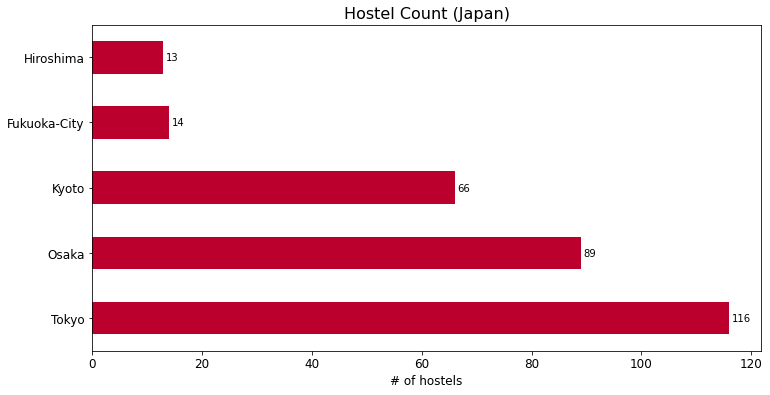

In [81]:
plt.figure(figsize=(12, 6))
ax = hostel_df.City.value_counts().plot(kind="barh", color="#BC002D", fontsize=12)
ax.set_title("Hostel Count (Japan)", fontsize=16)
ax.set_xlabel("# of hostels", fontsize=12)

for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width() + 0.5, p.get_y() + 0.2))

Tokyo has the most number of hostels which is understandable since it is once of the largest cities of the world and hence might attract a lot of visitors through its airport


Going ahead, our focus will only be tokyo hostels

In [82]:
tokyo_hostels_df.head()

,Name,City,StartPrice,DistanceFromCityCentre,OverallScore,RatingCategory,Atmosphere,Cleanliness,Facilities,Location,Security,Staff,ValueForMoney,Longitude,Latitude,Address,Neighborhood
2,&And Hostel Akihabara,Tokyo,3600,7.8,8.7,Fabulous,8.0,7.0,9.0,8.0,10.0,10.0,9.0,139.777472,35.697447,"unnamed road, Kanda, Chiyoda, 101-0025, Japan",Chiyoda
3,&And Hostel Ueno,Tokyo,2600,8.7,7.4,Very Good,8.0,7.5,7.5,7.5,7.0,8.0,6.5,139.783667,35.712716,"unnamed road, Higashiueno 6-chome, Taito, 110-...",Taito
4,&And Hostel-Asakusa North-,Tokyo,1500,10.5,9.4,Superb,9.5,9.5,9.0,9.0,9.5,10.0,9.5,139.798371,35.727898,"unnamed road, Nihonzutsumi 2-chome, Taito, 111...",Taito
5,1night1980hostel Tokyo,Tokyo,2100,9.4,7.0,Very Good,5.5,8.0,6.0,6.0,8.5,8.5,6.5,139.786950,35.724384,"unnamed road, Shitaya 3-chome, Taito, 110-0004...",Taito
6,328 Hostel & Lounge,Tokyo,3300,16.5,9.3,Superb,8.7,9.7,9.3,9.1,9.3,9.7,8.9,139.745467,35.548044,"328 Hostel&Lounge, 8 Shuto Expressway Route 1 ...",Ota


In [83]:
tokyo_hostels_df.shape

(115, 17)

Let's visualize all these hostels on the map

In [86]:
tokyo_map = folium.Map(location=(35.689487, 139.691711), zoom_start=11)

# add markers to map
for lat, lng, label in zip(tokyo_hostels_df.Latitude, tokyo_hostels_df.Longitude, tokyo_hostels_df.Name):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='#BC002D',
        fill=True,
        fill_color='#FFF',
        fill_opacity=0.75,
        parse_html=False).add_to(tokyo_map)
    
tokyo_map

### Chloropleth: Hostel Density

Let's visualize how many hostels are located in each neighborhood

In [109]:
hostels_density = tokyo_hostels_df.groupby('Neighborhood')['Name'].count().to_frame().reset_index()
hostels_density.columns = ['Neighborhood', 'Count']
hostels_density.sort_values(['Count'], ascending=False)[:5]

,Neighborhood,Count
18,Taito,39
3,Chuo,13
17,Sumida,10
2,Chiyoda,9
16,Shinjuku,9


In [111]:
import geopandas

gdf = geopandas.read_file('data/tokyo.json')
gdf.head()

,area,area_en,code,geometry
0,Adachi Ku,Tokubu,131211.0,"POLYGON ((139.82105 35.81508, 139.82168 35.814..."
1,Bunkyo Ku,Tokubu,131059.0,"POLYGON ((139.76093 35.73221, 139.76100 35.732..."
2,Chiyoda Ku,Tokubu,131016.0,"POLYGON ((139.77014 35.70535, 139.77017 35.705..."
3,Taito Ku,Tokubu,131067.0,"POLYGON ((139.80971 35.72814, 139.80971 35.727..."
4,Shinagawa Ku,Tokubu,131091.0,"MULTIPOLYGON (((139.71920 35.64185, 139.71935 ..."


In [112]:
hostels_density.Neighborhood = hostels_density.Neighborhood + ' Ku'

In [113]:
hostels_density.head()

,Neighborhood,Count
0,Adachi Ku,2
1,Bunkyo Ku,2
2,Chiyoda Ku,9
3,Chuo Ku,13
4,Edogawa Ku,1


In [114]:
gdf = gdf.merge(hostels_density, left_on="area", right_on="Neighborhood")
gdf.head()

,area,area_en,code,geometry,Neighborhood,Count
0,Adachi Ku,Tokubu,131211.0,"POLYGON ((139.82105 35.81508, 139.82168 35.814...",Adachi Ku,2
1,Bunkyo Ku,Tokubu,131059.0,"POLYGON ((139.76093 35.73221, 139.76100 35.732...",Bunkyo Ku,2
2,Chiyoda Ku,Tokubu,131016.0,"POLYGON ((139.77014 35.70535, 139.77017 35.705...",Chiyoda Ku,9
3,Taito Ku,Tokubu,131067.0,"POLYGON ((139.80971 35.72814, 139.80971 35.727...",Taito Ku,39
4,Shinagawa Ku,Tokubu,131091.0,"MULTIPOLYGON (((139.71920 35.64185, 139.71935 ...",Shinagawa Ku,2


In [115]:
import branca

colormap = branca.colormap.LinearColormap(
    colors=['#FFF9C4','#FFF176','#FFCA28','#FF9800','#D84315'],
    index=gdf['Count'].quantile([0.25, 0.5, 0.7, 0.9]),
    vmin=hostels_density.Count.min(),
    vmax=hostels_density.Count.max()
)

colormap.caption="Hostel Density in Tokyo"

In [138]:
tokyo_map = folium.Map(location=(35.689487, 139.691711), zoom_start=11)

gj = folium.GeoJson(
    gdf,
    style_function=lambda x: {'fillColor': colormap(x['properties']['Count']), 'color': '#000',
                                                    'weight':0.25, 'fillOpacity':0.75},

).add_to(tokyo_map)

tokyo_map

We can see from the map where the neighborhoods **Taito** and **Chuo** are very clearly


Let's checkout the most expensive neighborhoods and number of hostels in that region:

In [139]:
gdf_new = gdf[['Neighborhood', 'Count']]
gdf_new.Neighborhood = gdf.Neighborhood.str.strip(" Ku")
cnt_price_df = gdf_new.merge(price_df, on="Neighborhood").sort_values('PricePerSqMeter', ascending=False).reset_index(drop=True)
cnt_price_df.head()

/home/adam/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,Neighborhood,Count,PricePerSqMeter
0,Chiyoda,9,2839779
1,Minato,3,2075876
2,Chuo,13,1876597
3,Shibuya,4,1193412
4,Taito,39,970843


Let's checkout the least expensive neighborhoods and number of hostels in that region:

In [140]:
cnt_price_df.tail()

,Neighborhood,Count,PricePerSqMeter
11,Nakano,3,584593
12,Ota,4,556757
13,Nerima,1,408850
14,Edogawa,1,334899
15,Adachi,2,293587


Now, let's take a look at all the neighborhoods

In [141]:
cnt_price_df.sort_values(['Count', 'PricePerSqMeter'])

,Neighborhood,Count,PricePerSqMeter
14,Edogawa,1,334899
13,Nerima,1,408850
6,Meguro,1,857665
15,Adachi,2,293587
9,Setagaya,2,671528
7,Shinagawa,2,775938
5,Bunkyo,2,952715
11,Nakano,3,584593
1,Minato,3,2075876
12,Ota,4,556757


* Sumida-Ku seems to be popular since it ranks third in the list of number of hostels and at the same time, it is the 4th cheapest neighborhood in our list
* The price of property(per sq. meter) in Sumita-Ku is almost 43% less than that in Taito-ku, which combined wih the fact that it is close to Taito-ku and has fewer hostels than Taito-ku, makes it an exciting prospect for new investors.

#### Q. How does price vary with distance from city center?

As per me, the closer a hostel to the city center, the higher it's price. Let's see if we can prove that using data.

In [143]:
tokyo_hostels_df.StartPrice.value_counts()

2000       13
2500       12
2200       10
3000        8
3300        6
2400        6
1800        5
2600        5
2100        5
2300        4
1600        4
3600        4
2900        4
1500        3
3200        3
2700        3
4100        2
4000        2
3800        2
1900        2
3700        2
3900        1
7600        1
5400        1
3400        1
3500        1
1003200     1
5500        1
6300        1
1300        1
5200        1
Name: StartPrice, dtype: int64

We can see that one hostel has a very high starting price! Can a hostel charge 1003200 Yen? Doesn't seem likely. Hence, we will remove that row from the dataset.

In [144]:
tokyo_hostels_df = tokyo_hostels_df[tokyo_hostels_df.StartPrice < 1000000]

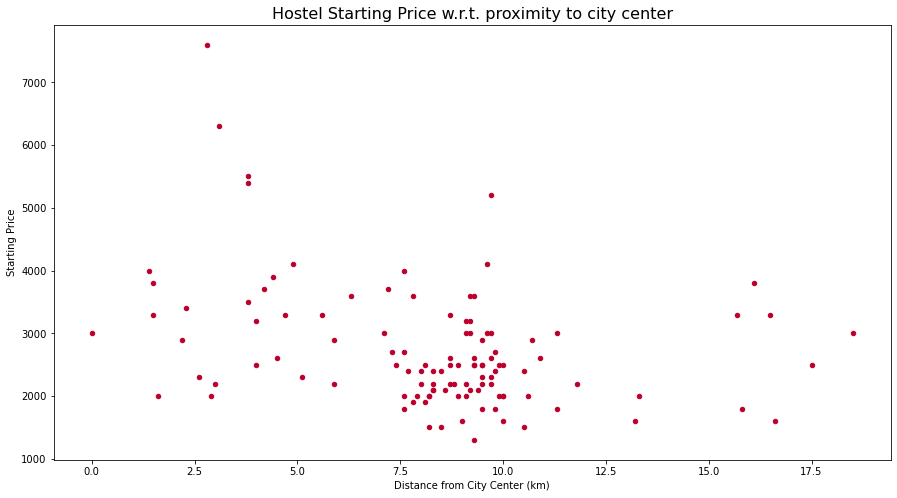

In [145]:
tokyo_hostels_df.plot(x='DistanceFromCityCentre', y='StartPrice', kind='scatter', figsize=(15, 8), color='#BC002D')
plt.xlabel("Distance from City Center (km)")
plt.ylabel("Starting Price")
plt.title("Hostel Starting Price w.r.t. proximity to city center", fontsize=16)
plt.show()

We cannot see any pattern which can help us verify our assumption. If our assumption was correct, we should be be seeing a curve which decreases as distance increases. However, there is no such curve visible.


Let's check the correlation score of StartPrice with DistanceFromCityCentre

In [146]:
tokyo_hostels_df[['StartPrice', 'DistanceFromCityCentre']].corr()

,StartPrice,DistanceFromCityCentre
StartPrice,1.000000,-0.338872
DistanceFromCityCentre,-0.338872,1.000000


The correlation coefficient is very low. Hence, we can say that the starting price of hostels does not vary according to its distance from the city center.

   **The starting price of hostels does not vary much depending on its distance from the city center.**

#### Q. Which hostels are most secure and where are they located?

I have no idea as to where the most secure hostels are located. Let's find out!

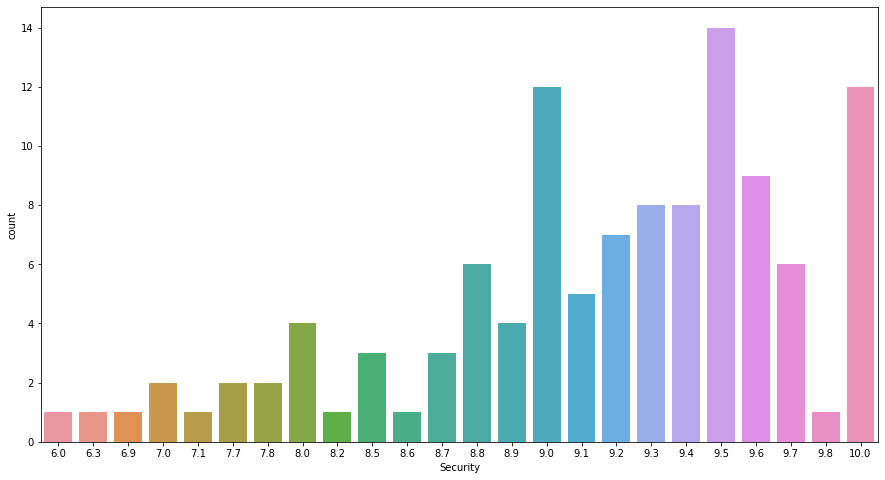

In [147]:
plt.figure(figsize=(15,8))
sns.countplot(x=tokyo_hostels_df.Security)

As we can see, most hostels are quite secure as rated by users, so that's some great news for travellers. Let's put hostels with security rating 9.5 and above on the map.

In [148]:
highsec_hostels = tokyo_hostels_df[tokyo_hostels_df.Security > 9]
lowsec_hostels = tokyo_hostels_df[tokyo_hostels_df.Security <= 9]

In [149]:


tokyo_map = folium.Map(location=(35.689487, 139.691711), zoom_start=11)

# add markers to map
for lat, lng, label in zip(highsec_hostels.Latitude, highsec_hostels.Longitude, highsec_hostels.Name):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='#33cc33',
        fill=True,
        fill_color='#FFF',
        fill_opacity=0.75,
        parse_html=False).add_to(tokyo_map)
    
# add markers to map
for lat, lng, label in zip(lowsec_hostels.Latitude, lowsec_hostels.Longitude, lowsec_hostels.Name):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='#BC002D',
        fill=True,
        fill_color='#FFF',
        fill_opacity=0.75,
        parse_html=False).add_to(tokyo_map)
    
tokyo_map

Let's try to visualize

In [150]:
highsec_hostel_areas = highsec_hostels.groupby('Neighborhood')['Name'].count().to_frame().reset_index()
highsec_hostel_areas.rename(columns={'Name': 'Count'}, inplace=True)
highsec_hostel_areas['Total'] = tokyo_hostels_df[tokyo_hostels_df.Neighborhood.isin(highsec_hostel_areas.Neighborhood)].groupby('Neighborhood')['Name'].count().values

In [151]:
highsec_hostel_areas['% High Security'] = np.round(highsec_hostel_areas.Count/highsec_hostel_areas.Total, decimals=2)*100
highsec_hostel_areas.sort_values(['% High Security', 'Count'], ascending=False)

,Neighborhood,Count,Total,% High Security
10,Shibuya,4,4,100.0
4,Katsushika,3,3,100.0
1,Bunkyo,2,2,100.0
5,Kita,2,2,100.0
6,Meguro,1,1,100.0
13,Sumida,9,10,90.0
3,Chuo,11,13,85.0
2,Chiyoda,6,9,67.0
7,Minato,2,3,67.0
14,Taito,25,39,64.0


We can see that Katsushika, Kita, Meguro, Shibuya and Shinagawa have 100% safe hostels. Let's see them on a map and check if they are nearby.

In [152]:
highsec_gdf = gdf[gdf.Neighborhood.isin(highsec_hostel_areas[highsec_hostel_areas['% High Security']==100].Neighborhood + ' Ku')]
highsec_gdf

,area,area_en,code,geometry,Neighborhood,Count
1,Bunkyo Ku,Tokubu,131059.0,"POLYGON ((139.76093 35.73221, 139.76100 35.732...",Bunkyo Ku,2
7,Shibuya Ku,Tokubu,131130.0,"POLYGON ((139.68399 35.69199, 139.68445 35.692...",Shibuya Ku,4
8,Kita Ku,Tokubu,131172.0,"POLYGON ((139.69767 35.79845, 139.69828 35.798...",Kita Ku,2
16,Meguro Ku,Tokubu,131105.0,"POLYGON ((139.71764 35.64166, 139.71764 35.641...",Meguro Ku,1
17,Katsushika Ku,Tokubu,131229.0,"POLYGON ((139.85879 35.79444, 139.85899 35.794...",Katsushika Ku,3


In [154]:
tokyo_map = folium.Map(location=(35.689487, 139.691711), zoom_start=11)

gj = folium.GeoJson(
    highsec_gdf,
    style_function=lambda x: {'fillColor': '#BC002D', 'color': '#000',
                                                    'weight':0.25, 'fillOpacity':0.5},
    
).add_to(tokyo_map)

tokyo_map

**Hostels with the very high security score are in Katsushika, Kita, Meguro, Shibuya and Shinagawa**

#### Q. Where are the 'value of money' hostels located?

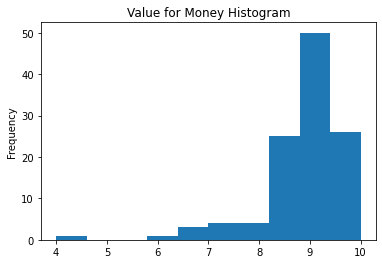

In [155]:
tokyo_hostels_df.ValueForMoney.plot(kind="hist")
plt.title("Value for Money Histogram")
plt.show()

Let's place hostels with highest 'value for money' rating

In [156]:
tokyo_map = folium.Map(location=(35.689487, 139.691711), zoom_start=11)
high_vfm = tokyo_hostels_df[tokyo_hostels_df.ValueForMoney == 10]
low_vfm = tokyo_hostels_df[tokyo_hostels_df.ValueForMoney <= 8]

# add markers to map
for lat, lng, label in zip(high_vfm.Latitude, high_vfm.Longitude, high_vfm.Name):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#33cc33',
        fill=True,
        fill_color='#FFF',
        fill_opacity=0.75,
        parse_html=False).add_to(tokyo_map)
    
tokyo_map

In [157]:
low_vfm.StartPrice.mean()

3390.909090909091

In [158]:
high_vfm.StartPrice.mean()

2781.818181818182

In [159]:
print("Distance from city center:")
print("Low Value for money: ", round(low_vfm.DistanceFromCityCentre.mean(), 2))
print("High Value for money: ", round(high_vfm.DistanceFromCityCentre.mean(), 2))

Distance from city center:
Low Value for money:  7.76
High Value for money:  9.9





Let's visualise neighborhoods according to value for money score.

In [160]:
nbr_vfm = tokyo_hostels_df.groupby('Neighborhood')['ValueForMoney'].mean().reset_index()
nbr_vfm.Neighborhood =  nbr_vfm.Neighborhood + " Ku"
vfm_gdf = pd.merge(gdf, nbr_vfm, on='Neighborhood')
vfm_gdf.head()

,area,area_en,code,geometry,Neighborhood,Count,ValueForMoney
0,Adachi Ku,Tokubu,131211.0,"POLYGON ((139.82105 35.81508, 139.82168 35.814...",Adachi Ku,2,9.150000
1,Bunkyo Ku,Tokubu,131059.0,"POLYGON ((139.76093 35.73221, 139.76100 35.732...",Bunkyo Ku,2,8.850000
2,Chiyoda Ku,Tokubu,131016.0,"POLYGON ((139.77014 35.70535, 139.77017 35.705...",Chiyoda Ku,9,9.288889
3,Taito Ku,Tokubu,131067.0,"POLYGON ((139.80971 35.72814, 139.80971 35.727...",Taito Ku,39,8.979487
4,Shinagawa Ku,Tokubu,131091.0,"MULTIPOLYGON (((139.71920 35.64185, 139.71935 ...",Shinagawa Ku,2,8.650000


In [161]:
colormap = branca.colormap.LinearColormap(
    colors=['#FFF9C4', '#F0F4C3', '#DCE775','#689F38'],
    index=vfm_gdf['ValueForMoney'].quantile([0.1, 0.2, 0.75, 0.9]),
    vmin=hostels_density.Count.min(),
    vmax=hostels_density.Count.max()
)

In [162]:
tokyo_map = folium.Map(location=(35.689487, 139.691711), zoom_start=11)

gj = folium.GeoJson(
    vfm_gdf,
    style_function=lambda x: {'fillColor': colormap(x['properties']['ValueForMoney']), 'color': '#000',
                                                    'weight':0.25, 'fillOpacity':0.75},
).add_to(tokyo_map)

tokyo_map

**High value for money hostels are comparatively cheaper and are located away from the city center**


**Hostels in Chiyoda are near city center and have high value for money rating as well**

#### Q. Cheap hostels near metro stations?

We will remove rows with Empty VenueCategory

In [164]:
tokyo_venues_df.Category.replace('', np.nan, inplace=True)
tokyo_venues_df.dropna(inplace=True)
tokyo_venues_df.shape

(8575, 5)

In [166]:
tokyo_venues_df.Category.value_counts()

Convenience Store        713
Ramen Restaurant         463
Café                     405
Sake Bar                 370
Coffee Shop              344
                        ... 
Coffee Roaster             1
Street Food Gathering      1
Burmese Restaurant         1
Cafeteria                  1
Wings Joint                1
Name: Category, Length: 304, dtype: int64

Let's check the average number of venues per Hostel

In [167]:
tokyo_venues_df.groupby('HostelName').count()

,VenueName,Category,VenueLatitude,VenueLongitude
HostelName,,,,
&And Hostel Akihabara,100,100,100,100
&And Hostel Ueno,83,83,83,83
&And Hostel-Asakusa North-,38,38,38,38
1night1980hostel Tokyo,33,33,33,33
328 Hostel & Lounge,65,65,65,65
...,...,...,...,...
YADOYA Guesthouse Green,41,41,41,41
YADOYA Guesthouse Orange,96,96,96,96
YAWP! backpackers,23,23,23,23


Let's extract the hostels which are close to Metro Stations.

In [168]:
metro_hostels = tokyo_venues_df[tokyo_venues_df.Category.str.contains('Station')]

metro_hostels

,HostelName,VenueName,Category,VenueLatitude,VenueLongitude
75,&And Hostel Akihabara,Akihabara Station (秋葉原駅),Train Station,35.698357,139.773120
77,&And Hostel Akihabara,Akihabara Electric Town Exit (秋葉原駅 電気街口),Train Station,35.698818,139.772570
176,&And Hostel Ueno,Iriya Entrance (JR上野駅 入谷口),Train Station,35.714337,139.778622
387,328 Hostel & Lounge,ホテル JAL CITY バス乗り場,Bus Station,35.551771,139.748390
893,ARTnSHELTER,関東運輸局 東京運輸支局,Vehicle Inspection Station,35.604789,139.746476
1351,Astro Station,ステーショナリーと印刷のお店 CHIKUHO,Stationery Store,35.712255,139.704978
1835,Beagle Tokyo Hostel & Apartments,Ōtorii Station (KK13) (大鳥居駅),Train Station,35.552223,139.741087
2336,Book And Bed Tokyo Ikebukuro,西武池袋駅 B1F改札口,Train Station,35.727878,139.710640
2339,Book And Bed Tokyo Ikebukuro,Loft (池袋ロフト),Stationery Store,35.728704,139.711455
2370,Book And Bed Tokyo Ikebukuro,Seibu South Exit (西武南口),Train Station,35.727852,139.710579


In [169]:
metro_hostels = tokyo_hostels_df[tokyo_hostels_df.Name.isin(metro_hostels.HostelName)]
metro_hostels.shape

(23, 17)

In [170]:
metro_hostels.RatingCategory.value_counts()

Superb       12
Fabulous      8
Very Good     2
Rating        1
Name: RatingCategory, dtype: int64

In [171]:
tokyo_hostels_df.RatingCategory.value_counts()

Superb       63
Fabulous     38
Very Good    11
Rating        1
Good          1
Name: RatingCategory, dtype: int64

In [172]:
print("Hostels located near a metro/train/bus station:")
print(f"{metro_hostels.RatingCategory.value_counts()['Fabulous']/metro_hostels.RatingCategory.value_counts().sum()*100}% were rated Fabulous")

Hostels located near a metro/train/bus station:
34.78260869565217% were rated Fabulous


In [173]:
print("In general:")
print(f"{tokyo_hostels_df.RatingCategory.value_counts()['Fabulous']/tokyo_hostels_df.RatingCategory.value_counts().sum()*100}% were rated Fabulous")

In general:
33.33333333333333% were rated Fabulous


We can observe above that 34% of the hostels near metro/train/bus stations were rated Fabulous compared to only 33% in general.

This shows that there is probably no correlation between the proximity to mode of transportation and the overall rating of the hostel

**The proportion of hostels rated fabulous is the same near metro/bus/train stations than in general.**

Which neighborhood venues affect a user's rating for location of hostel?

Let's do a similar analysis for a few categories and see how it affects the user rating.

We'll do similar analysis for Convenience Store, Restaurant, Bar, Shopping Mall categories

In [174]:
hostels_near_store = tokyo_hostels_df[
    tokyo_hostels_df.Name.isin(tokyo_venues_df.HostelName[tokyo_venues_df.Category.str.contains('store', case=False)])]

In [175]:
hostels_near_store.RatingCategory.value_counts()

Superb       63
Fabulous     37
Very Good    11
Rating        1
Good          1
Name: RatingCategory, dtype: int64

In [176]:
print("Hostels located near a convenience store:")
print(f"{hostels_near_store.RatingCategory.value_counts()['Fabulous']/hostels_near_store.RatingCategory.value_counts().sum()*100}% were rated Fabulous")

Hostels located near a convenience store:
32.743362831858406% were rated Fabulous


**Travellers do not bother much about proximity to a convenience store doesn't since it doesn't seem to affect overall hostel rating.**

Let's check for public parks

In [177]:
hostels_near_park = tokyo_hostels_df[
    tokyo_hostels_df.Name.isin(tokyo_venues_df.HostelName[tokyo_venues_df.Category.str.contains('park', case=False)])]

In [178]:
hostels_near_park.RatingCategory.value_counts()

Superb       38
Fabulous     21
Very Good     3
Rating        1
Good          1
Name: RatingCategory, dtype: int64

In [181]:
print("Hostels located near a public park:")
print(f"{hostels_near_park.RatingCategory.value_counts()['Fabulous']/hostels_near_park.RatingCategory.value_counts().sum()*100}% were rated Fabulous")

Hostels located near a public park:
32.8125% were rated Fabulous


**Hostels with proximity to a park are quite lowly rated than others. Seems like travellers do not like public parks near hostels.**

Lets check hostels near historic sites

In [182]:
hostels_near_site = tokyo_hostels_df[
    tokyo_hostels_df.Name.isin(tokyo_venues_df.HostelName[tokyo_venues_df.Category.str.contains('Historic Site', case=False)])]

In [183]:
hostels_near_site.RatingCategory.value_counts()

Superb       7
Fabulous     6
Very Good    2
Good         1
Name: RatingCategory, dtype: int64

In [184]:
print("Hostels located near a historic site:")
print(f"{hostels_near_site.RatingCategory.value_counts()['Fabulous']/hostels_near_site.RatingCategory.value_counts().sum()*100}% were rated Fabulous")

Hostels located near a historic site:
37.5% were rated Fabulous


**The proportion of hostels rated fabulous is more near a historic site than in general.**

In [185]:
hostels_near_museum = tokyo_hostels_df[
    tokyo_hostels_df.Name.isin(tokyo_venues_df.HostelName[tokyo_venues_df.Category.str.contains('Museum', case=False)])]

In [186]:
hostels_near_museum.RatingCategory.value_counts()

Superb       14
Fabulous      7
Very Good     4
Rating        1
Name: RatingCategory, dtype: int64

In [187]:
print("Hostels located near a museum:")
print(f"{hostels_near_museum.RatingCategory.value_counts()['Fabulous']/hostels_near_museum.RatingCategory.value_counts().sum()*100}% were rated Fabulous")

Hostels located near a museum:
26.923076923076923% were rated Fabulous


**Proportion of Hostels with proximity to a museum that are lowly rated is quite high than in general.**

## 5.2 Clustering

Now, we will cluster the hostels twice. Once depending on the different rating parameters and one based on their neighborhood.

Consider the following case, that a traveller has selected a hostel, but he finds that it is full! What options does he have? He/She can either go for a hostel which is similar in rating and price to the one he/she has selected. Or he/she can consider hostels which boast similar neighborhood to the selected one.

We will help traveller in both cases

### 5.2.1 Clustering based on rating parameters

In [188]:
X = tokyo_hostels_df[['StartPrice', 'DistanceFromCityCentre', 'OverallScore', 
                      'Atmosphere', 'Cleanliness', 'Facilities', 'Location', 
                      'Security', 'Staff', 'ValueForMoney']]

In [189]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [190]:
scores = [get_inertia(x) for x in range(2, 21)]

Text(0, 0.5, 'Error')

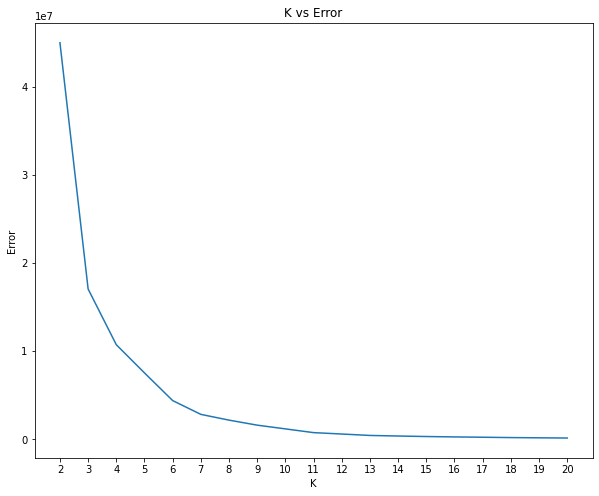

In [191]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores)
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

It is evident from the above plot that we have 6 clusters in our data. Let's retrain the model and plot the hostels on the map.

In [192]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

KMeans(n_clusters=6)

In [193]:
tokyo_hostels_df['RatingCluster'] = kmeans.labels_

<ipython-input-193-3ea4f42e9975>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokyo_hostels_df['RatingCluster'] = kmeans.labels_


In [194]:
tokyo_map = folium.Map(location=(35.689487, 139.691711), zoom_start=11)

# set color scheme for the clusters
x = np.arange(9)
ys = [i + x + (i*x)**2 for i in range(9)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
markers_colors = []
for lat, lng, name, cluster in zip(tokyo_hostels_df.Latitude, tokyo_hostels_df.Longitude, tokyo_hostels_df.Name, kmeans.labels_):
    label = folium.Popup(str(name) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color='#FFF',
        fill_opacity=0.75,
        parse_html=False).add_to(tokyo_map)
    
tokyo_map

**Examining Clusters**

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. But we won't be doing it for all. We'll compare first two clusters for the sake of brevity

**Cluster 1** (best value for money cluster)

In [195]:
tokyo_hostels_df[tokyo_hostels_df.RatingCluster == 0].describe()

,StartPrice,DistanceFromCityCentre,OverallScore,Atmosphere,Cleanliness,Facilities,Location,Security,Staff,ValueForMoney,Longitude,Latitude,RatingCluster
count,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.00000,40.000000,40.000000,40.0
mean,2417.50000,8.560000,8.887500,8.205000,9.107500,8.767500,8.882500,9.150000,9.200000,8.89500,139.778235,35.701880,0.0
std,161.54304,2.504028,0.601361,1.145549,0.833709,0.772737,0.641667,0.639311,0.585728,0.78314,0.034174,0.024223,0.0
min,2200.00000,2.600000,7.400000,4.000000,6.000000,6.800000,6.800000,7.000000,7.300000,6.50000,139.668125,35.604242,0.0
25%,2275.00000,7.925000,8.600000,7.800000,8.900000,8.300000,8.675000,9.000000,9.000000,8.67500,139.775749,35.694450,0.0
50%,2450.00000,8.850000,9.000000,8.200000,9.300000,8.900000,9.000000,9.300000,9.350000,8.95000,139.785828,35.703397,0.0
75%,2500.00000,9.700000,9.300000,8.900000,9.600000,9.300000,9.300000,9.500000,9.600000,9.40000,139.794945,35.712317,0.0
max,2700.00000,17.500000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,139.869197,35.753926,0.0


**Cluster 2** (more costly hostels that dont offer much more quality compared to cluster 1 they are closer to the centre)

In [196]:
tokyo_hostels_df[tokyo_hostels_df.RatingCluster == 1].describe()

,StartPrice,DistanceFromCityCentre,OverallScore,Atmosphere,Cleanliness,Facilities,Location,Security,Staff,ValueForMoney,Longitude,Latitude,RatingCluster
count,14.000000,14.000000,14.000000,14.00000,14.000000,14.00000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.0
mean,3785.714286,6.664286,8.671429,8.15000,8.921429,8.20000,8.757143,8.664286,9.185714,8.785714,139.745607,35.692388,1.0
std,203.269972,3.828156,0.722633,1.11338,1.117813,1.03478,0.672211,1.305378,0.758396,0.995264,0.037821,0.044775,0.0
min,3500.000000,1.400000,6.800000,6.00000,6.700000,6.00000,8.000000,6.000000,7.300000,6.700000,139.693004,35.550492,1.0
25%,3600.000000,4.250000,8.475000,7.92500,8.100000,8.00000,8.000000,7.775000,8.700000,8.450000,139.704999,35.689835,1.0
50%,3750.000000,6.750000,8.950000,8.00000,9.300000,8.50000,8.950000,9.050000,9.300000,8.950000,139.748664,35.704967,1.0
75%,3975.000000,8.850000,9.100000,8.97500,9.700000,9.00000,9.375000,9.600000,9.875000,9.275000,139.777024,35.713089,1.0
max,4100.000000,16.100000,9.400000,10.00000,10.000000,9.30000,9.700000,10.000000,10.000000,10.000000,139.794981,35.731081,1.0


**Cluster 3** (Just one hostel in this cluster, very expensive, close to the centre)

In [197]:
tokyo_hostels_df[tokyo_hostels_df.RatingCluster == 2].describe()

,StartPrice,DistanceFromCityCentre,OverallScore,Atmosphere,Cleanliness,Facilities,Location,Security,Staff,ValueForMoney,Longitude,Latitude,RatingCluster
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0
mean,7600.0,2.8,8.4,8.0,9.0,9.0,8.0,8.0,9.0,8.0,139.722998,35.689721,2.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,7600.0,2.8,8.4,8.0,9.0,9.0,8.0,8.0,9.0,8.0,139.722998,35.689721,2.0
25%,7600.0,2.8,8.4,8.0,9.0,9.0,8.0,8.0,9.0,8.0,139.722998,35.689721,2.0
50%,7600.0,2.8,8.4,8.0,9.0,9.0,8.0,8.0,9.0,8.0,139.722998,35.689721,2.0
75%,7600.0,2.8,8.4,8.0,9.0,9.0,8.0,8.0,9.0,8.0,139.722998,35.689721,2.0
max,7600.0,2.8,8.4,8.0,9.0,9.0,8.0,8.0,9.0,8.0,139.722998,35.689721,2.0


**Cluster 4** (Cheapest hostels, further from city centre)

In [198]:
tokyo_hostels_df[tokyo_hostels_df.RatingCluster == 3].describe()

,StartPrice,DistanceFromCityCentre,OverallScore,Atmosphere,Cleanliness,Facilities,Location,Security,Staff,ValueForMoney,Longitude,Latitude,RatingCluster
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.0
mean,1863.636364,9.309091,8.772727,8.275758,8.969697,8.654545,8.327273,9.124242,9.069697,8.996970,139.780810,35.716049,3.0
std,219.114955,2.821498,0.589636,0.847065,1.015346,0.800426,1.361817,0.644705,0.723051,0.585494,0.039389,0.027145,0.0
min,1300.000000,1.600000,7.000000,5.500000,6.000000,6.000000,4.000000,7.000000,6.500000,6.500000,139.667695,35.674781,3.0
25%,1800.000000,8.200000,8.700000,8.000000,8.900000,8.300000,8.300000,8.800000,8.900000,8.800000,139.777275,35.695490,3.0
50%,2000.000000,9.100000,9.000000,8.400000,9.300000,8.900000,8.900000,9.200000,9.300000,9.100000,139.785988,35.711877,3.0
75%,2000.000000,10.000000,9.100000,8.800000,9.500000,9.000000,9.100000,9.500000,9.400000,9.200000,139.796697,35.727547,3.0
max,2100.000000,16.600000,9.400000,10.000000,10.000000,10.000000,9.700000,10.000000,10.000000,10.000000,139.863871,35.807266,3.0


**Cluster 5** (Expensive hostels close to the city centre with high quality service and cleanliness)

In [199]:
tokyo_hostels_df[tokyo_hostels_df.RatingCluster == 4].describe()

,StartPrice,DistanceFromCityCentre,OverallScore,Atmosphere,Cleanliness,Facilities,Location,Security,Staff,ValueForMoney,Longitude,Latitude,RatingCluster
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0
mean,5600.000000,5.100000,9.400000,8.975000,9.900000,9.650000,9.325000,9.625000,9.350000,9.050000,139.719876,35.672133,4.0
std,483.045892,3.084369,0.182574,0.298608,0.141421,0.251661,0.518813,0.095743,0.331662,0.412311,0.049455,0.029331,0.0
min,5200.000000,3.100000,9.200000,8.700000,9.700000,9.300000,8.700000,9.500000,8.900000,8.700000,139.692916,35.655097,4.0
25%,5350.000000,3.625000,9.275000,8.850000,9.850000,9.600000,9.000000,9.575000,9.200000,8.700000,139.692970,35.655314,4.0
50%,5450.000000,3.800000,9.400000,8.900000,9.950000,9.700000,9.400000,9.650000,9.450000,9.000000,139.696342,35.658791,4.0
75%,5700.000000,5.275000,9.525000,9.025000,10.000000,9.750000,9.725000,9.700000,9.600000,9.350000,139.723248,35.675611,4.0
max,6300.000000,9.700000,9.600000,9.400000,10.000000,9.900000,9.800000,9.700000,9.600000,9.500000,139.793905,35.715853,4.0


**Cluster 6** (Average hostels all around)

In [200]:
tokyo_hostels_df[tokyo_hostels_df.RatingCluster == 5].describe()

,StartPrice,DistanceFromCityCentre,OverallScore,Atmosphere,Cleanliness,Facilities,Location,Security,Staff,ValueForMoney,Longitude,Latitude,RatingCluster
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.0
mean,3109.090909,8.186364,8.690909,8.231818,8.936364,8.209091,8.368182,9.095455,9.354545,8.618182,139.755119,35.683704,5.0
std,168.774549,4.795563,1.050129,1.596242,1.396780,1.880706,1.603682,0.760625,0.741124,1.328672,0.057574,0.053014,0.0
min,2900.000000,0.000000,4.900000,2.000000,4.000000,2.000000,2.000000,6.300000,6.900000,4.000000,139.603321,35.548044,5.0
25%,3000.000000,4.925000,8.600000,8.000000,8.825000,7.875000,8.000000,8.900000,9.050000,8.500000,139.721524,35.670297,5.0
50%,3000.000000,9.100000,9.050000,8.250000,9.350000,8.800000,8.900000,9.000000,9.500000,8.800000,139.758115,35.698645,5.0
75%,3300.000000,9.675000,9.300000,9.175000,9.675000,9.300000,9.100000,9.500000,9.875000,9.375000,139.792050,35.715136,5.0
max,3400.000000,18.500000,9.600000,10.000000,10.000000,10.000000,9.800000,10.000000,10.000000,10.000000,139.877880,35.759783,5.0


Now suppose that I want to stay at **Retrometro Backpackers**. However, when I go to book, it shows that it doesn't have any spots available! Fortunately, I can now use the cluster result to find a hostel similar to Retrometro Backpackers. Let's see what options do I have!

In [201]:
tokyo_hostels_df[tokyo_hostels_df.Name.str.contains("Retrometro")]

,Name,City,StartPrice,DistanceFromCityCentre,OverallScore,RatingCategory,Atmosphere,Cleanliness,Facilities,Location,Security,Staff,ValueForMoney,Longitude,Latitude,Address,Neighborhood,RatingCluster
275,Retrometro Backpackers,Tokyo,3000,9.2,9.4,Superb,9.4,9.4,9.0,9.4,9.5,9.8,9.6,139.789362,35.713157,"Retrometro Backpackers, Kappabashi Dogugai Str...",Taito,5


Retrometro Backpackers' RatingCluster is 5. Let's see what options do I have!

In [202]:
tokyo_hostels_df[tokyo_hostels_df.RatingCluster == 5].sort_values(['OverallScore'], ascending=False)[:5]

,Name,City,StartPrice,DistanceFromCityCentre,OverallScore,RatingCategory,Atmosphere,Cleanliness,Facilities,Location,Security,Staff,ValueForMoney,Longitude,Latitude,Address,Neighborhood,RatingCluster
132,Hostel bedgasm,Tokyo,2900,9.5,9.6,Superb,9.6,9.8,9.6,9.1,9.5,9.9,9.7,139.789033,35.721350,"Taisho Elementary School, Kimbikan-dori, Iriya...",Taito,5
329,Unplan Kagurazaka,Tokyo,3200,4.0,9.5,Superb,9.2,9.9,9.6,8.8,9.6,9.8,9.6,139.731323,35.705065,"unnamed road, Tenjincho, Shinjuku, 162-0805, J...",Shinjuku,5
275,Retrometro Backpackers,Tokyo,3000,9.2,9.4,Superb,9.4,9.4,9.0,9.4,9.5,9.8,9.6,139.789362,35.713157,"Retrometro Backpackers, Kappabashi Dogugai Str...",Taito,5
227,Lyuro Tokyo Kiyosumi -The Share Hotels-,Tokyo,3200,9.1,9.4,Superb,9.3,10.0,10.0,7.3,10.0,9.3,10.0,139.792066,35.681217,"LYURO東京清澄, Sumidagawa Sagan-dori, Kiyosumi 1-c...",Sumida,5
6,328 Hostel & Lounge,Tokyo,3300,16.5,9.3,Superb,8.7,9.7,9.3,9.1,9.3,9.7,8.9,139.745467,35.548044,"328 Hostel&Lounge, 8 Shuto Expressway Route 1 ...",Ota,5


  * Fortunately I can book a bed at Hostel bedgasm! It is similarly priced and rated as Retrometro Backpackers!

  * We can do the same for the other 5 clusters as well, but we are not doing that now.

### 5.2.2 Clustering based on neighborhood

Now, we will cluster the same hostels. But this time, we will not use ratings or price instead we will use the neighborhood data and see which hostels have similar surroundings. Some travellers focus more on the location of a place rather than the price or ratings. This can be useful for them.

We will do one-hot encoding for the Category column to convert them to features

In [203]:
category_1hot = pd.get_dummies(tokyo_venues_df.Category)
category_1hot['HostelName'] = tokyo_venues_df.HostelName

# move neighborhood column to the first column
fixed_columns = [category_1hot.columns[-1]] + list(category_1hot.columns[:-1])
category_1hot = category_1hot[fixed_columns]
category_1hot.head()

,HostelName,ATM,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Wagashi Place,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yakitori Restaurant,Yoshoku Restaurant,Zoo,Zoo Exhibit
75,&And Hostel Akihabara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76,&And Hostel Akihabara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77,&And Hostel Akihabara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78,&And Hostel Akihabara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79,&And Hostel Akihabara,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [204]:
category_1hot.shape

(8575, 305)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [205]:
category_1hot = category_1hot.groupby('HostelName').mean().reset_index()
category_1hot.head()

,HostelName,ATM,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Wagashi Place,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yakitori Restaurant,Yoshoku Restaurant,Zoo,Zoo Exhibit
0,&And Hostel Akihabara,0.000000,0.0,0.01,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.020000,0.0,0.0
1,&And Hostel Ueno,0.000000,0.0,0.00,0.012048,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.012048,0.0,0.0
2,&And Hostel-Asakusa North-,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0
3,1night1980hostel Tokyo,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.030303,0.0,0.0
4,328 Hostel & Lounge,0.015385,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.030769,0.0,0.0


Let's see few Hostels along with the top 5 most common venues

In [206]:
num_top_venues = 5

for nbrhood in category_1hot.HostelName[:5]:
    print("---- "+nbrhood+" ----")
    temp = category_1hot[category_1hot.HostelName == nbrhood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- &And Hostel Akihabara ----
              venue  freq
0          Sake Bar  0.14
1  Ramen Restaurant  0.08
2   Soba Restaurant  0.05
3         BBQ Joint  0.04
4        Hobby Shop  0.04


---- &And Hostel Ueno ----
                venue  freq
0   Convenience Store  0.18
1    Ramen Restaurant  0.10
2                Café  0.06
3  Chinese Restaurant  0.05
4     Bed & Breakfast  0.05


---- &And Hostel-Asakusa North- ----
               venue  freq
0  Convenience Store  0.21
1              Hotel  0.16
2           Sake Bar  0.11
3             Hostel  0.05
4      Grocery Store  0.05


---- 1night1980hostel Tokyo ----
                venue  freq
0   Convenience Store  0.18
1       Grocery Store  0.09
2              Hostel  0.09
3        Intersection  0.06
4  Chinese Restaurant  0.06


---- 328 Hostel & Lounge ----
                 venue  freq
0    Convenience Store  0.12
1  Japanese Restaurant  0.09
2                 Café  0.06
3                Hotel  0.06
4     Ramen Restaurant  0.06




**Let's put that into a pandas dataframe**

In [207]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [208]:
indicators = ['st', 'nd', 'rd']
num_top_venues = 10

# create columns according to number of top venues
columns = ['HostelName']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nbr_venues_sorted_df = pd.DataFrame(columns=columns)
nbr_venues_sorted_df['HostelName'] = category_1hot.HostelName

for ind in np.arange(category_1hot.shape[0]):
    nbr_venues_sorted_df.iloc[ind, 1:] = return_most_common_venues(category_1hot.iloc[ind, :], num_top_venues)

nbr_venues_sorted_df.head()

,HostelName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,&And Hostel Akihabara,Sake Bar,Ramen Restaurant,Soba Restaurant,BBQ Joint,Hobby Shop,Café,Sushi Restaurant,Chinese Restaurant,Steakhouse,Music Store
1,&And Hostel Ueno,Convenience Store,Ramen Restaurant,Café,Chinese Restaurant,Bed & Breakfast,Coffee Shop,Hotel,Japanese Restaurant,Soba Restaurant,Kitchen Supply Store
2,&And Hostel-Asakusa North-,Convenience Store,Hotel,Sake Bar,Hostel,Grocery Store,Outdoor Sculpture,Café,Supermarket,Sushi Restaurant,Tree
3,1night1980hostel Tokyo,Convenience Store,Grocery Store,Hostel,Intersection,Chinese Restaurant,Supermarket,Hotel,Teishoku Restaurant,Sake Bar,Café
4,328 Hostel & Lounge,Convenience Store,Japanese Restaurant,Café,Hotel,Ramen Restaurant,Boat or Ferry,Yoshoku Restaurant,Intersection,Bus Stop,Sake Bar


**Clustering Neighborhoods**

Let's cluster neighborhoods into 4 types based on venue categories.

In [209]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=15, random_state=8)
X = category_1hot.drop(['HostelName'], axis=1)
X.head()

,ATM,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Wagashi Place,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yakitori Restaurant,Yoshoku Restaurant,Zoo,Zoo Exhibit
0,0.000000,0.0,0.01,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.020000,0.0,0.0
1,0.000000,0.0,0.00,0.012048,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.012048,0.0,0.0
2,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.030303,0.0,0.0
4,0.015385,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.030769,0.0,0.0


In [210]:
kmeans.fit(X)

KMeans(max_iter=15, n_clusters=4, random_state=8)

In [211]:
nbr_venues_sorted_df['Cluster'] = kmeans.labels_
nbr_venues_sorted_df.rename(columns={'HostelName': 'Name'}, inplace=True)

In [212]:
tokyo_hostels_df_merged = pd.merge(tokyo_hostels_df, nbr_venues_sorted_df, on='Name')
tokyo_hostels_df_merged.head()

,Name,City,StartPrice,DistanceFromCityCentre,OverallScore,RatingCategory,Atmosphere,Cleanliness,Facilities,Location,...,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
0,&And Hostel Akihabara,Tokyo,3600,7.8,8.7,Fabulous,8.0,7.0,9.0,8.0,...,Ramen Restaurant,Soba Restaurant,BBQ Joint,Hobby Shop,Café,Sushi Restaurant,Chinese Restaurant,Steakhouse,Music Store,1
1,&And Hostel Ueno,Tokyo,2600,8.7,7.4,Very Good,8.0,7.5,7.5,7.5,...,Ramen Restaurant,Café,Chinese Restaurant,Bed & Breakfast,Coffee Shop,Hotel,Japanese Restaurant,Soba Restaurant,Kitchen Supply Store,2
2,&And Hostel-Asakusa North-,Tokyo,1500,10.5,9.4,Superb,9.5,9.5,9.0,9.0,...,Hotel,Sake Bar,Hostel,Grocery Store,Outdoor Sculpture,Café,Supermarket,Sushi Restaurant,Tree,2
3,1night1980hostel Tokyo,Tokyo,2100,9.4,7.0,Very Good,5.5,8.0,6.0,6.0,...,Grocery Store,Hostel,Intersection,Chinese Restaurant,Supermarket,Hotel,Teishoku Restaurant,Sake Bar,Café,2
4,328 Hostel & Lounge,Tokyo,3300,16.5,9.3,Superb,8.7,9.7,9.3,9.1,...,Japanese Restaurant,Café,Hotel,Ramen Restaurant,Boat or Ferry,Yoshoku Restaurant,Intersection,Bus Stop,Sake Bar,0


**Finally, let's visualize the resulting clusters**

In [213]:
# create map
tokyo_map = folium.Map(location=(35.689487, 139.691711), zoom_start=11)

# set color scheme for the clusters
x = np.arange(9)
ys = [i + x + (i*x)**2 for i in range(9)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tokyo_hostels_df_merged['Latitude'], tokyo_hostels_df_merged['Longitude'], tokyo_hostels_df_merged['Name'], tokyo_hostels_df_merged['Cluster']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster) + ')', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color='#FFF',
        fill_opacity=0.7).add_to(tokyo_map)

In [214]:
tokyo_map

**Examine Clusters**

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

**Cluster 1** (Stores and restaurants)

In [215]:
tokyo_hostels_df_merged.loc[tokyo_hostels_df_merged['Cluster'] == 0, tokyo_hostels_df_merged.columns[[0] + list(range(18, tokyo_hostels_df_merged.shape[1]))]][:5]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
4,328 Hostel & Lounge,Convenience Store,Japanese Restaurant,Café,Hotel,Ramen Restaurant,Boat or Ferry,Yoshoku Restaurant,Intersection,Bus Stop,Sake Bar,0
10,Anne Hostel Yokozuna,Convenience Store,Soba Restaurant,Sake Bar,Nabe Restaurant,History Museum,Ramen Restaurant,Café,Museum,BBQ Joint,Tempura Restaurant,0
12,AS House (Asakusa Smile),Convenience Store,Soba Restaurant,Café,Unagi Restaurant,Japanese Restaurant,Intersection,Wagashi Place,French Restaurant,Art Gallery,Bakery,0
36,Guest House Shinagawa-shuku Tokyo,Convenience Store,Sake Bar,Japanese Restaurant,Café,Ramen Restaurant,Shopping Mall,Park,Chinese Restaurant,Restaurant,Tempura Restaurant,0
46,Hostel bedgasm,Soba Restaurant,Hostel,Grocery Store,Ramen Restaurant,Convenience Store,Bus Stop,Steakhouse,Takoyaki Place,Supermarket,Sushi Restaurant,0


In [225]:
tokyo_hostels_df_merged.loc[tokyo_hostels_df_merged['Cluster'] == 0]['1st Most Common Venue'].value_counts()

Convenience Store      14
Soba Restaurant         2
Japanese Restaurant     2
Coffee Shop             1
Café                    1
Zoo Exhibit             1
Chinese Restaurant      1
Intersection            1
Name: 1st Most Common Venue, dtype: int64

**Cluster 2** (Bars and clubs)

In [217]:
tokyo_hostels_df_merged.loc[tokyo_hostels_df_merged['Cluster'] == 1, tokyo_hostels_df_merged.columns[[0] + list(range(18, tokyo_hostels_df_merged.shape[1]))]][:5]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
0,&And Hostel Akihabara,Sake Bar,Ramen Restaurant,Soba Restaurant,BBQ Joint,Hobby Shop,Café,Sushi Restaurant,Chinese Restaurant,Steakhouse,Music Store,1
5,Ace Inn Shinjuku,Convenience Store,Sake Bar,Ramen Restaurant,BBQ Joint,Japanese Restaurant,Bar,Italian Restaurant,Grocery Store,Café,Tonkatsu Restaurant,1
7,Akihabara Hotel 3000,Sake Bar,Ramen Restaurant,Soba Restaurant,Café,Tonkatsu Restaurant,BBQ Joint,Japanese Restaurant,Steakhouse,Dessert Shop,Music Store,1
8,Almond hostel & cafe Shibuya,Italian Restaurant,Sake Bar,Bakery,Park,Café,Coffee Shop,Japanese Restaurant,BBQ Joint,Chocolate Shop,Burger Joint,1
9,Anne Hostel Asakusabashi,Convenience Store,Yoshoku Restaurant,Sake Bar,Soba Restaurant,Café,Ramen Restaurant,BBQ Joint,Nabe Restaurant,Tempura Restaurant,Thai Restaurant,1


In [218]:
tokyo_hostels_df_merged.loc[tokyo_hostels_df_merged['Cluster'] == 1]['1st Most Common Venue'].value_counts()

Sake Bar                     9
Ramen Restaurant             7
Convenience Store            3
Nightclub                    2
Korean Restaurant            2
Café                         1
BBQ Joint                    1
Japanese Curry Restaurant    1
Japanese Restaurant          1
Yoshoku Restaurant           1
Italian Restaurant           1
Bar                          1
Chinese Restaurant           1
Name: 1st Most Common Venue, dtype: int64

**Cluster 3** (Close to a convenience store)

In [219]:
tokyo_hostels_df_merged.loc[tokyo_hostels_df_merged['Cluster'] == 2, tokyo_hostels_df_merged.columns[[0] + list(range(18, tokyo_hostels_df_merged.shape[1]))]][:5]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
1,&And Hostel Ueno,Convenience Store,Ramen Restaurant,Café,Chinese Restaurant,Bed & Breakfast,Coffee Shop,Hotel,Japanese Restaurant,Soba Restaurant,Kitchen Supply Store,2
2,&And Hostel-Asakusa North-,Convenience Store,Hotel,Sake Bar,Hostel,Grocery Store,Outdoor Sculpture,Café,Supermarket,Sushi Restaurant,Tree,2
3,1night1980hostel Tokyo,Convenience Store,Grocery Store,Hostel,Intersection,Chinese Restaurant,Supermarket,Hotel,Teishoku Restaurant,Sake Bar,Café,2
6,Aizuya Inn,Convenience Store,Hotel,Sake Bar,Intersection,Hostel,Grocery Store,Tea Room,Motel,Historic Site,Tempura Restaurant,2
11,ARTnSHELTER,Convenience Store,Chinese Restaurant,Ramen Restaurant,Soba Restaurant,Canal,Park,Sake Bar,BBQ Joint,Cafeteria,Fishing Spot,2


In [220]:
tokyo_hostels_df_merged.loc[tokyo_hostels_df_merged['Cluster'] == 2]['1st Most Common Venue'].value_counts()

Convenience Store    36
Sake Bar              1
Name: 1st Most Common Venue, dtype: int64

**Cluster 4** (Cafees and restaurants)

In [221]:
tokyo_hostels_df_merged.loc[tokyo_hostels_df_merged['Cluster'] == 3, tokyo_hostels_df_merged.columns[[0] + list(range(18, tokyo_hostels_df_merged.shape[1]))]][:5]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
13,Asakusa Hostel Toukaisou,Coffee Shop,Ramen Restaurant,Convenience Store,Café,Kitchen Supply Store,Hotel,Chinese Restaurant,Arts & Crafts Store,Yoshoku Restaurant,Sake Bar,3
14,Asakusa Ryokan Toukaisou,Coffee Shop,Ramen Restaurant,Convenience Store,Café,Kitchen Supply Store,Hotel,Chinese Restaurant,Arts & Crafts Store,Yoshoku Restaurant,Sake Bar,3
15,Asakusahotel Wasou,Café,Coffee Shop,Unagi Restaurant,Ramen Restaurant,Soba Restaurant,Yoshoku Restaurant,Sukiyaki Restaurant,Hotel,Dessert Shop,Japanese Restaurant,3
19,Book And Bed Tokyo Asakusa,Café,Coffee Shop,Ramen Restaurant,Japanese Restaurant,Sukiyaki Restaurant,Unagi Restaurant,Yoshoku Restaurant,Soba Restaurant,Bed & Breakfast,Italian Restaurant,3
21,Bunka Hostel Tokyo,Ramen Restaurant,Coffee Shop,Café,Sukiyaki Restaurant,Dessert Shop,Convenience Store,Unagi Restaurant,Hotel,Yoshoku Restaurant,Teishoku Restaurant,3


In [222]:
tokyo_hostels_df_merged.loc[tokyo_hostels_df_merged['Cluster'] == 3]['1st Most Common Venue'].value_counts()

Ramen Restaurant       7
Café                   6
Coffee Shop            5
Dessert Shop           2
Convenience Store      2
Japanese Restaurant    1
Name: 1st Most Common Venue, dtype: int64

## 6. Conclusion

We got a glimpse of the hostel scene in Tokyo and were able to find out some interesting insights which might be useful to travellers as well as people with business interests. Let's summarize our findings:

   * Most hostels are located in Taito-ku and Chuo-ku.
   * Sumita-ku seems to be an interesting locality since it is close to Taito-ku and 43% cheaper than Taito-ku.
   * The starting price of hostels does not vary much depending on its distance from the city center.
   * Most of the hostels rated high for their security are in Katsushika, Kita, Meguro, Shibuya and Shinagawa
   * Hostels rated highly for being value for money are comparatively cheaper and are located away from the city center

In addition, we also clustered the hostels, first based on the different rating parameters, and second based on the neighborhood of the hostels. It can useful for travellers to identify a alternate hostel.

There are many things which I have assumed while making the above claims since we were working with limited data. I'll try to expand the dataset for a more comprehensive study.

Until then, sayonara!